<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/pil_editor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from PIL import Image, ImageChops,ImageOps
import time

def sort_imgs(imgs:list):
  narray = np.arange(0,len(imgs))
  for i in range(len(imgs)):
    rate = imgs[i].size[0] / imgs[i].size[1]
    result = False if 0.76 < rate < 1.24 else True
    print(i,result,imgs[i].size,rate)
    if result:break
    narray = np.roll(narray,-1)
    print(narray)
  new_imgs = [imgs[i] for i in narray]
  return new_imgs


def resize(img,img_size):
  '''
  resize image to img_size

  Parameters
  ----------
  img : Image
    PIL Image
  img_size : int
    resize image size
  
  Returns
  -------
  image: Image
    resized image
  '''
  width = img.size[0]
  height = img.size[1]
  rate_x = img_size / width
  rate_y = img_size / height
  rate = rate_x if rate_x < rate_y else rate_y
  width = int(width * rate)
  height = int(height * rate)
  if img_size - width == 1:width = img_size
  if img_size - height == 1:hegith = img_size
  return img.resize((width,height), Image.ANTIALIAS)

def crop_image(path:str)->Image:
  image = Image.open(path)
  # getpixel(0, 0) で左上の色を取得し、背景色のみの画像を作成する
  bgc = image.getpixel((0, 0))
  print('bgc',bgc)
  bg = Image.new(image.mode, image.size,bgc)

  fix_image = ImageOps.autocontrast(image,0.5)
  # 背景色画像と元画像の差分を取得
  diff = ImageChops.difference(fix_image, bg)
  diff = ImageChops.add(diff, diff, 2.0, -100)
  # 黒背景の境界Boxを取り出す
  bbox = diff.getbbox()
  # 元画像を切り出す
  cropped = image.crop(bbox)
  return cropped


def triple_images(imgs,img_size):
  x,y,x1,y1 = 0,0,0,0

  # image 1
  imgs[0] = resize(imgs[0],img_size)
  print('imgs[0].size',imgs[0].size)

  space_x = img_size - imgs[0].size[0]
  if space_x == 0:
    space_y = img_size - imgs[0].size[1]
    space_x = img_size
  else:
    space_x = img_size - imgs[0].size[0]
    space_y = img_size
  print('space_x',space_x,'space_y',space_y)
  imgs[1].thumbnail((space_x,space_y))

  if imgs[0].size[0] != img_size: x1 = imgs[0].size[0] 
  if imgs[0].size[1] != img_size: y1 = imgs[0].size[1] 
  print('x1',x1,'y1',y1)

  # image 2
  print('imgs[1].size',imgs[1].size)
  x2,y2 = x1,y1
  if x1 == 0: x2 = imgs[1].size[0]
  if y1 == 0: y2 = imgs[1].size[1]
  if x1 == x2 and y2 == img_size:
    x2 = imgs[0].size[0] + imgs[1].size[0] 
    y2 = 0
  if y1 == y2 and x2 == img_size:
    y2 = imgs[0].size[1] + imgs[1].size[1]
    x2 = 0
  print('x2',x2,'y2',y2)

  space_x = img_size - x2
  space_y = img_size - y2
  if space_x == 0:space_x = img_size
  if space_y == 0:space_y = img_size
  print('space_x',space_x,'space_y',space_y)

  imgs[2].thumbnail((space_x,space_y))
  print('imgs[2]',imgs[2].size)

  # make background
  bgc = imgs[0].getpixel((imgs[0].size[0]-1,imgs[0].size[1]-1))
  bg = Image.new('RGB',(img_size,img_size),bgc)

  xm,ym = 0,0
  if imgs[0].size[0] == img_size: 
    xm = img_size - imgs[1].size[0] - imgs[2].size[0] 
    xm = int(xm/2)
  if imgs[0].size[1] == img_size: 
    ym = img_size - imgs[1].size[1] - imgs[2].size[1] 
    ym = int(ym/2)
  if xm < 0:xm = 0
  if ym < 0:ym = 0
  print('xm,ym',xm,ym)

  x_weight = imgs[1].size[0]/img_size
  y_weight = imgs[1].size[1]/img_size
  print('x_weight',x_weight,'y_weight',y_weight)

  x_weight2 = imgs[2].size[0]/img_size
  y_weight2 = imgs[2].size[1]/img_size
  print('x_weight2',x_weight2,'y_weight2',y_weight2)    

  bg.paste(imgs[0],(x,y)  ) # image 1
  if x_weight > 0.15 and y_weight > 0.15:bg.paste(imgs[1],(xm + x1,ym + y1)) # image 2
  if x_weight2 > 0.15 and y_weight2 > 0.15:bg.paste(imgs[2],(xm + x2,ym + y2)) # image 3

  if 3 < len(imgs) and x_weight2 > 0.15 and y_weight2 > 0.15 and xm == 0 and ym == 0 and imgs[0].size[1] == img_size:
    if img_size * 2 == imgs[0].size[1] + imgs[1].size[1]:
      print('ストレート')
      x3 = imgs[0].size[0] + imgs[1].size[0]
      y3 = imgs[2].size[1]
    else:
      x3 = imgs[0].size[0] + imgs[1].size[0]
      y3 = img_size
    print('x3',x3,'y3',y3)
    imgs[3].thumbnail((img_size - x3,img_size - y3))
    if img_size / 3 < imgs[3].size[0] or img_size / 3 < imgs[3].size[1]:
      bg.paste(imgs[3],(x3,y3)) # image 3
  return bg

bgc (255, 255, 255)
bgc (255, 255, 255)
bgc (229, 228, 226)
bgc (255, 255, 255)
0 True (518, 2326) 0.2226999140154772
imgs[0].size (111, 500)
space_x 389 space_y 500
x1 111 y1 0
imgs[1].size (189, 500)
x2 300 y2 0
space_x 200 space_y 500
imgs[2] (200, 299)
xm,ym 0 0
x_weight 0.378 y_weight 1.0
x_weight2 0.4 y_weight2 0.598
ストレート
x3 300 y3 299
1.641343116760254


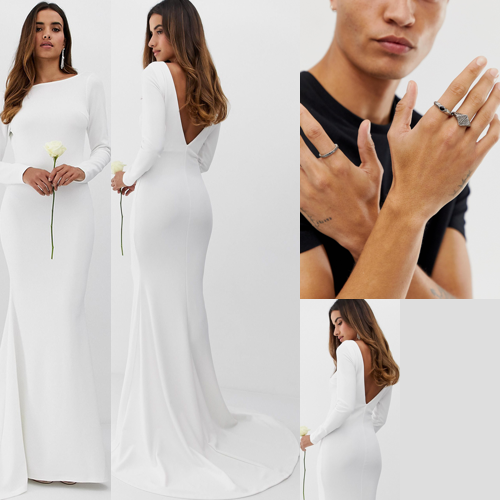

In [187]:
img_paths = ['/content/a02.jpg','/content/a01.jpg','/content/a03.jpg','/content/a03.jpg']
# img_paths = ['/content/a01.jpg','/content/a02.jpg','/content/a03.jpg','/content/a03.jpg']
img_paths = ['/content/002/a01.jpg','/content/002/a02.jpg','/content/002/a03.jpg','/content/002/a03.jpg']
img_paths = ['/content/002/a01.jpg','/content/002/a02.jpg','/content/12030065/a03.jpg','/content/002/a03.jpg']
# img_paths = ['/content/12030065/a03.jpg','/content/12030065/a02.jpg','/content/12030065/a01.jpg','/content/12030065/a04.jpg']
# img_paths = ['/content/8934106/a03.jpg','/content/8934106/a01.jpg','/content/8934106/a02.jpg','/content/8934106/a04.jpg']
# img_paths = ['/content/11004955/a04.jpg','/content/11004955/a02.jpg','/content/11004955/a01.jpg','/content/11004955/a03.jpg']
# img_paths = ['/content/11006540/a03.jpg','/content/11006540/a02.jpg','/content/11006540/a01.jpg','/content/11006540/a04.jpg']
# img_paths = ['/content/11004770/a01.jpg','/content/11004770/a04.jpg','/content/11004770/a03.jpg','/content/11004770/a02.jpg']
# img_paths = ['/content/11063515/a01.jpg','/content/11063515/a02.jpg','/content/11063515/a03.jpg','/content/11063515/a04.jpg']
# img_paths = ['/content/10589422/a03.jpg','/content/10589422/a02.jpg','/content/10589422/a04.jpg','/content/10589422/a01.jpg']
# img_paths = ['/content/10990068/a03.jpg','/content/10990068/a02.jpg','/content/10990068/a01.jpg','/content/10990068/a04.jpg']
# img_paths = ['/content/10990068/a01.jpg','/content/10990068/a02.jpg','/content/10990068/a03.jpg','/content/10990068/a04.jpg']
start = time.time()
imgs = [crop_image(path) for path in img_paths]
imgs = sort_imgs(imgs)
img_size = 500
new_image = triple_images(imgs,img_size)
print(time.time() - start)
new_image

In [0]:
!unzip small_sample.zip
!unzip shoes_sample.zip
!unzip middle_sample.zip

In [2]:
!unzip error_sample.zip

Archive:  error_sample.zip
replace 11063515/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!unzip 002.zip